**Chargement et exploration de dataset**

In [1]:
import numpy as np 
import pandas as pd 

# les notes des utilisateurs depuis u.data
ratings = pd.read_csv("/kaggle/input/movielens-100k-dataset/ml-100k/u.data")
ratings = pd.read_csv("/kaggle/input/movielens-100k-dataset/ml-100k/u.data", sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])
print(ratings)

# les métadonnées des films depuis u.item 
movies = pd.read_csv("/kaggle/input/movielens-100k-dataset/ml-100k/u.item", sep="|", encoding="latin-1", 
                     names=["movie_id", "title", "release_date", "video_release_date", "IMDb_URL", "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"])
print(movies)

# les informations sur les utilisateurs
users = pd.read_csv("/kaggle/input/movielens-100k-dataset/ml-100k/u.user", sep="|", names=["user_id", "age", "gender", "occupation", "zip_code"])
print(users)

       user_id  movie_id  rating  timestamp
0          196       242       3  881250949
1          186       302       3  891717742
2           22       377       1  878887116
3          244        51       2  880606923
4          166       346       1  886397596
...        ...       ...     ...        ...
99995      880       476       3  880175444
99996      716       204       5  879795543
99997      276      1090       1  874795795
99998       13       225       2  882399156
99999       12       203       3  879959583

[100000 rows x 4 columns]
      movie_id                                      title release_date  \
0            1                           Toy Story (1995)  01-Jan-1995   
1            2                           GoldenEye (1995)  01-Jan-1995   
2            3                          Four Rooms (1995)  01-Jan-1995   
3            4                          Get Shorty (1995)  01-Jan-1995   
4            5                             Copycat (1995)  01-Jan-1995   
.

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


**Prétraitement**

In [2]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split

# Nettoyage
ratings.drop('timestamp', axis=1, inplace=True)

# Normalisation des notes dans [0,1]
ratings['rating'] = (ratings['rating'] - 1.0) / 4.0

# Fusion pour garder les titres (pas obligatoire mais utile pour l'interprétation)
data = pd.merge(ratings, movies[['movie_id', 'title']], on='movie_id')

# Réindexation des IDs pour embeddings
unique_user_ids = data['user_id'].unique()
unique_movie_ids = data['movie_id'].unique()

user_id_map = {id_: idx for idx, id_ in enumerate(unique_user_ids)}
movie_id_map = {id_: idx for idx, id_ in enumerate(unique_movie_ids)}

data['user_id'] = data['user_id'].map(user_id_map)
data['movie_id'] = data['movie_id'].map(movie_id_map)

# Extraction finale des données
user_ids = data['user_id'].values
movie_ids = data['movie_id'].values
ratings = data['rating'].values

# Split Train / Test
train_user, test_user, train_movie, test_movie, train_rating, test_rating = train_test_split(
    user_ids, movie_ids, ratings, test_size=0.2, random_state=42)

print("Nombre d'utilisateurs:", len(unique_user_ids))
print("Nombre de films:", len(unique_movie_ids))
print("Train size:", len(train_rating))
print("Test size:", len(test_rating))


Nombre d'utilisateurs: 943
Nombre de films: 1682
Train size: 80000
Test size: 20000


**NCF**

In [6]:
import torch
from torch import nn

class NeuralColabFilteringNet(nn.Module):
    def __init__(self, 
                 user_count,
                 movie_count,
                 embedding_size=64,       # réduit pour ce dataset
                 hidden_layers=(128, 64, 32),  # MLP plus léger
                 dropout_rate=0.3,        # dropout modéré
                 output_range=(0, 1)):
        super().__init__()

        # Embeddings utilisateurs et films
        self.user_embedding = nn.Embedding(user_count, embedding_size)
        self.movie_embedding = nn.Embedding(movie_count, embedding_size)
        
        # Génération des couches MLP
        self.MLP = self._gen_MLP(embedding_size, hidden_layers, dropout_rate)

        # Paramètres pour re-scaler la sortie
        assert len(output_range) == 2, "output_range doit être un tuple de 2 éléments"
        self.norm_min = output_range[0]
        self.norm_range = output_range[1] - output_range[0]

        # Initialisation des poids
        self._init_params()

    def _gen_MLP(self, embedding_size, hidden_layers_units, dropout_rate):
        """
        Crée la partie MLP
        """
        layers = []
        input_units = 2 * embedding_size  # concat embeddings user + movie

        for num_units in hidden_layers_units:
            layers.append(nn.Linear(input_units, num_units))
            layers.append(nn.ReLU())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            input_units = num_units
        
        # Couche de sortie
        layers.append(nn.Linear(input_units, 1))
        layers.append(nn.Sigmoid())  # sortie normalisée [0,1]

        return nn.Sequential(*layers)

    def _init_params(self):
        """
        Initialisation des poids
        """
        nn.init.uniform_(self.user_embedding.weight, -0.05, 0.05)
        nn.init.uniform_(self.movie_embedding.weight, -0.05, 0.05)

        for m in self.MLP:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0.01)

    def forward(self, user_id, movie_id):
        user_feat = self.user_embedding(user_id)
        movie_feat = self.movie_embedding(movie_id)
        x = torch.cat([user_feat, movie_feat], dim=1)
        x = self.MLP(x)
        return x * self.norm_range + self.norm_min  # rescale sortie


**Affichage du modèle**

In [7]:
import torch
from random import randrange

# Choix du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Définir le nombre total d'utilisateurs et de films
user_count = len(unique_user_ids)
movie_count = len(unique_movie_ids)

# Instanciation du modèle OptimizedNCF
ncf = OptimizedNCF(user_count=user_count, movie_count=movie_count).to(device)
print(f"\nOur model architecture:\n{ncf}\n")

# Nombre de paramètres et estimation mémoire
num_params = sum(p.numel() for p in ncf.parameters())
print(f'Number of model parameters: {num_params:,}, estimated training size: {num_params*4/(1024**2):.2f} MB')

# Test "dry run" : prédiction aléatoire pour vérifier que le modèle fonctionne
ratings_sample_idx = randrange(0, len(data) - 1)

test_user = int(data.iloc[ratings_sample_idx].user_id)
test_movie = int(data.iloc[ratings_sample_idx].movie_id)
actual_rating = float(data.iloc[ratings_sample_idx].rating)

# Prédiction
ncf.eval()  # mode évaluation
with torch.no_grad():
    predicted_rating = ncf(torch.tensor([test_user], device=device),
                           torch.tensor([test_movie], device=device))

print(f"Dry run prediction for user_id={test_user} and movie_id={test_movie}: {predicted_rating.item():.4f}, actual rating: {actual_rating}")

Using device: cuda

Our model architecture:
OptimizedNCF(
  (user_embedding): Embedding(943, 64)
  (movie_embedding): Embedding(1682, 64)
  (MLP): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

Number of model parameters: 194,881, estimated training size: 0.74 MB
Dry run prediction for user_id=413 and movie_id=1138: 0.5071, actual rating: 0.75


**Entrainement**

In [10]:
# ---------------- Dataset Iterator ----------------
class DatasetBatchIterator:
    def __init__(self, X, Y, batch_size, shuffle=True):
        self.X = np.asarray(X)
        self.Y = np.asarray(Y)
        if shuffle:
            index = np.random.permutation(X.shape[0])
            self.X = self.X[index]
            self.Y = self.Y[index]
        self.batch_size = batch_size
        self.n_batches = int(np.ceil(X.shape[0] / batch_size))
        self._current = 0

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        X_batch = torch.tensor(self.X[k * bs:(k + 1) * bs], dtype=torch.long)
        Y_batch = torch.tensor(self.Y[k * bs:(k + 1) * bs], dtype=torch.float)
        return X_batch, Y_batch.view(-1, 1)

    def __len__(self):
        return self.n_batches


In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm

# ---------------- Device ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Hyperparamètres ----------------
epochs = 50
batch_size = 2048
learning_rate = 0.001
weight_decay = 1e-5
step_size = 10
gamma = 0.1

# ---------------- Modèle & Optimizer ----------------
ncf = NeuralColabFilteringNet(user_count, movie_count).to(device)
optimizer = optim.Adam(ncf.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# ---------------- Préparation des données ----------------
datasets = {
    'train': (np.column_stack((train_user, train_movie)), train_rating),
    'test':  (np.column_stack((test_user, test_movie)), test_rating)
}

history = {
    'epoch': [], 
    'train_loss': [], 'train_rmse': [], 'train_mae': [],
    'val_loss': [], 'val_rmse': [], 'val_mae': []
}

# ---------------- Boucle d'entraînement ----------------
for epoch in range(epochs):
    epoch_start = time.perf_counter()

    # -------- Training --------
    ncf.train()
    running_loss, total_sq, total_abs, n_samples = 0.0, 0.0, 0.0, 0

    train_loader = DatasetBatchIterator(datasets['train'][0], datasets['train'][1], batch_size=batch_size)
    for x_batch, y_batch in tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{epochs}", unit="batch"):
        # Envoi des batchs sur le device
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = ncf(x_batch[:,0], x_batch[:,1])
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        # Statistiques
        running_loss += loss.item()
        total_sq += torch.sum((outputs - y_batch)**2).item()
        total_abs += torch.sum(torch.abs(outputs - y_batch)).item()
        n_samples += len(y_batch)

    scheduler.step()  # mise à jour du LR
    avg_train_loss = running_loss / len(train_loader)
    avg_train_rmse = (total_sq / n_samples)**0.5
    avg_train_mae = total_abs / n_samples

    # -------- Validation --------
    ncf.eval()
    val_loss, val_sq, val_abs, n_val = 0.0, 0.0, 0.0, 0
    with torch.no_grad():
        test_loader = DatasetBatchIterator(datasets['test'][0], datasets['test'][1], batch_size=batch_size, shuffle=False)
        for x_batch, y_batch in tqdm(test_loader, desc="Validation", unit="batch"):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = ncf(x_batch[:,0], x_batch[:,1])
            loss = criterion(outputs, y_batch)

            val_loss += loss.item()
            val_sq += torch.sum((outputs - y_batch)**2).item()
            val_abs += torch.sum(torch.abs(outputs - y_batch)).item()
            n_val += len(y_batch)

    avg_val_loss = val_loss / len(test_loader)
    avg_val_rmse = (val_sq / n_val)**0.5
    avg_val_mae = val_abs / n_val

    # -------- Mise à jour de l'historique --------
    history['epoch'].append(epoch+1)
    history['train_loss'].append(avg_train_loss)
    history['train_rmse'].append(avg_train_rmse)
    history['train_mae'].append(avg_train_mae)
    history['val_loss'].append(avg_val_loss)
    history['val_rmse'].append(avg_val_rmse)
    history['val_mae'].append(avg_val_mae)

    epoch_duration = time.perf_counter() - epoch_start
    print(f"Epoch [{epoch+1}/{epochs}] - Time: {epoch_duration:.2f}s | "
          f"Train Loss: {avg_train_loss:.4f}, RMSE: {avg_train_rmse:.4f}, MAE: {avg_train_mae:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, RMSE: {avg_val_rmse:.4f}, MAE: {avg_val_mae:.4f}")

Using device: cuda


Validation:   0%|          | 0/1 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2048, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Validation: 100%|██████████| 1/1 [00:00<00:00, 322.44batch/s]


Epoch [1/50] - Time: 0.60s | Train Loss: 0.0779, RMSE: 0.2793, MAE: 0.2297 | Val Loss: 0.0819, RMSE: 0.2862, MAE: 0.2406


Validation: 100%|██████████| 1/1 [00:00<00:00, 871.09batch/s]


Epoch [2/50] - Time: 0.11s | Train Loss: 0.0614, RMSE: 0.2478, MAE: 0.1955 | Val Loss: 0.0813, RMSE: 0.2851, MAE: 0.2272


Validation: 100%|██████████| 1/1 [00:00<00:00, 757.64batch/s]


Epoch [3/50] - Time: 0.11s | Train Loss: 0.0567, RMSE: 0.2376, MAE: 0.1890 | Val Loss: 0.0810, RMSE: 0.2845, MAE: 0.2275


Validation: 100%|██████████| 1/1 [00:00<00:00, 779.18batch/s]


Epoch [4/50] - Time: 0.11s | Train Loss: 0.0544, RMSE: 0.2332, MAE: 0.1852 | Val Loss: 0.0780, RMSE: 0.2794, MAE: 0.2317


Validation: 100%|██████████| 1/1 [00:00<00:00, 649.17batch/s]


Epoch [5/50] - Time: 0.11s | Train Loss: 0.0532, RMSE: 0.2305, MAE: 0.1827 | Val Loss: 0.0778, RMSE: 0.2789, MAE: 0.2327


Validation: 100%|██████████| 1/1 [00:00<00:00, 632.91batch/s]


Epoch [6/50] - Time: 0.11s | Train Loss: 0.0522, RMSE: 0.2285, MAE: 0.1811 | Val Loss: 0.0777, RMSE: 0.2788, MAE: 0.2334


Validation: 100%|██████████| 1/1 [00:00<00:00, 784.72batch/s]


Epoch [7/50] - Time: 0.11s | Train Loss: 0.0516, RMSE: 0.2276, MAE: 0.1802 | Val Loss: 0.0796, RMSE: 0.2821, MAE: 0.2290


Validation: 100%|██████████| 1/1 [00:00<00:00, 676.61batch/s]


Epoch [8/50] - Time: 0.11s | Train Loss: 0.0509, RMSE: 0.2255, MAE: 0.1784 | Val Loss: 0.0786, RMSE: 0.2804, MAE: 0.2304


Validation: 100%|██████████| 1/1 [00:00<00:00, 827.77batch/s]


Epoch [9/50] - Time: 0.11s | Train Loss: 0.0501, RMSE: 0.2241, MAE: 0.1772 | Val Loss: 0.0788, RMSE: 0.2807, MAE: 0.2302


Validation: 100%|██████████| 1/1 [00:00<00:00, 691.10batch/s]


Epoch [10/50] - Time: 0.11s | Train Loss: 0.0494, RMSE: 0.2226, MAE: 0.1759 | Val Loss: 0.0780, RMSE: 0.2792, MAE: 0.2320


Validation: 100%|██████████| 1/1 [00:00<00:00, 697.19batch/s]


Epoch [11/50] - Time: 0.11s | Train Loss: 0.0469, RMSE: 0.2174, MAE: 0.1713 | Val Loss: 0.0784, RMSE: 0.2800, MAE: 0.2309


Validation: 100%|██████████| 1/1 [00:00<00:00, 723.41batch/s]


Epoch [12/50] - Time: 0.11s | Train Loss: 0.0469, RMSE: 0.2165, MAE: 0.1704 | Val Loss: 0.0785, RMSE: 0.2801, MAE: 0.2307


Validation: 100%|██████████| 1/1 [00:00<00:00, 744.46batch/s]


Epoch [13/50] - Time: 0.11s | Train Loss: 0.0465, RMSE: 0.2157, MAE: 0.1698 | Val Loss: 0.0789, RMSE: 0.2809, MAE: 0.2299


Validation: 100%|██████████| 1/1 [00:00<00:00, 697.54batch/s]


Epoch [14/50] - Time: 0.11s | Train Loss: 0.0468, RMSE: 0.2157, MAE: 0.1697 | Val Loss: 0.0794, RMSE: 0.2818, MAE: 0.2292


Validation: 100%|██████████| 1/1 [00:00<00:00, 739.87batch/s]


Epoch [15/50] - Time: 0.11s | Train Loss: 0.0461, RMSE: 0.2147, MAE: 0.1690 | Val Loss: 0.0796, RMSE: 0.2821, MAE: 0.2290


Validation: 100%|██████████| 1/1 [00:00<00:00, 741.31batch/s]


Epoch [16/50] - Time: 0.11s | Train Loss: 0.0462, RMSE: 0.2145, MAE: 0.1686 | Val Loss: 0.0799, RMSE: 0.2827, MAE: 0.2286


Validation: 100%|██████████| 1/1 [00:00<00:00, 685.34batch/s]


Epoch [17/50] - Time: 0.11s | Train Loss: 0.0457, RMSE: 0.2138, MAE: 0.1682 | Val Loss: 0.0808, RMSE: 0.2842, MAE: 0.2277


Validation: 100%|██████████| 1/1 [00:00<00:00, 700.80batch/s]


Epoch [18/50] - Time: 0.11s | Train Loss: 0.0458, RMSE: 0.2132, MAE: 0.1676 | Val Loss: 0.0813, RMSE: 0.2852, MAE: 0.2272


Validation: 100%|██████████| 1/1 [00:00<00:00, 736.62batch/s]


Epoch [19/50] - Time: 0.13s | Train Loss: 0.0451, RMSE: 0.2128, MAE: 0.1670 | Val Loss: 0.0810, RMSE: 0.2847, MAE: 0.2275


Validation: 100%|██████████| 1/1 [00:00<00:00, 566.19batch/s]


Epoch [20/50] - Time: 0.12s | Train Loss: 0.0455, RMSE: 0.2125, MAE: 0.1667 | Val Loss: 0.0816, RMSE: 0.2856, MAE: 0.2270


Validation: 100%|██████████| 1/1 [00:00<00:00, 709.82batch/s]


Epoch [21/50] - Time: 0.11s | Train Loss: 0.0447, RMSE: 0.2116, MAE: 0.1660 | Val Loss: 0.0815, RMSE: 0.2855, MAE: 0.2270


Validation: 100%|██████████| 1/1 [00:00<00:00, 676.83batch/s]


Epoch [22/50] - Time: 0.11s | Train Loss: 0.0447, RMSE: 0.2115, MAE: 0.1660 | Val Loss: 0.0815, RMSE: 0.2855, MAE: 0.2270


Validation: 100%|██████████| 1/1 [00:00<00:00, 664.08batch/s]


Epoch [23/50] - Time: 0.11s | Train Loss: 0.0449, RMSE: 0.2115, MAE: 0.1660 | Val Loss: 0.0816, RMSE: 0.2856, MAE: 0.2270


Validation: 100%|██████████| 1/1 [00:00<00:00, 803.20batch/s]


Epoch [24/50] - Time: 0.11s | Train Loss: 0.0444, RMSE: 0.2110, MAE: 0.1656 | Val Loss: 0.0816, RMSE: 0.2857, MAE: 0.2269


Validation: 100%|██████████| 1/1 [00:00<00:00, 885.81batch/s]


Epoch [25/50] - Time: 0.11s | Train Loss: 0.0445, RMSE: 0.2112, MAE: 0.1659 | Val Loss: 0.0817, RMSE: 0.2858, MAE: 0.2269


Validation: 100%|██████████| 1/1 [00:00<00:00, 789.59batch/s]


Epoch [26/50] - Time: 0.11s | Train Loss: 0.0447, RMSE: 0.2113, MAE: 0.1657 | Val Loss: 0.0817, RMSE: 0.2859, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 728.94batch/s]


Epoch [27/50] - Time: 0.11s | Train Loss: 0.0446, RMSE: 0.2111, MAE: 0.1657 | Val Loss: 0.0817, RMSE: 0.2859, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 626.76batch/s]


Epoch [28/50] - Time: 0.11s | Train Loss: 0.0444, RMSE: 0.2112, MAE: 0.1657 | Val Loss: 0.0817, RMSE: 0.2859, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 665.23batch/s]


Epoch [29/50] - Time: 0.11s | Train Loss: 0.0447, RMSE: 0.2112, MAE: 0.1656 | Val Loss: 0.0818, RMSE: 0.2859, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 691.67batch/s]


Epoch [30/50] - Time: 0.11s | Train Loss: 0.0445, RMSE: 0.2111, MAE: 0.1657 | Val Loss: 0.0818, RMSE: 0.2860, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 993.20batch/s]


Epoch [31/50] - Time: 0.11s | Train Loss: 0.0447, RMSE: 0.2110, MAE: 0.1657 | Val Loss: 0.0818, RMSE: 0.2860, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 772.29batch/s]


Epoch [32/50] - Time: 0.11s | Train Loss: 0.0445, RMSE: 0.2108, MAE: 0.1654 | Val Loss: 0.0818, RMSE: 0.2860, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 740.52batch/s]


Epoch [33/50] - Time: 0.11s | Train Loss: 0.0445, RMSE: 0.2108, MAE: 0.1653 | Val Loss: 0.0818, RMSE: 0.2860, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 677.37batch/s]


Epoch [34/50] - Time: 0.11s | Train Loss: 0.0444, RMSE: 0.2109, MAE: 0.1656 | Val Loss: 0.0818, RMSE: 0.2860, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 608.49batch/s]


Epoch [35/50] - Time: 0.11s | Train Loss: 0.0445, RMSE: 0.2109, MAE: 0.1653 | Val Loss: 0.0818, RMSE: 0.2860, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 568.56batch/s]


Epoch [36/50] - Time: 0.11s | Train Loss: 0.0447, RMSE: 0.2111, MAE: 0.1656 | Val Loss: 0.0818, RMSE: 0.2860, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 767.77batch/s]


Epoch [37/50] - Time: 0.11s | Train Loss: 0.0446, RMSE: 0.2112, MAE: 0.1657 | Val Loss: 0.0818, RMSE: 0.2860, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 655.05batch/s]


Epoch [38/50] - Time: 0.11s | Train Loss: 0.0445, RMSE: 0.2111, MAE: 0.1656 | Val Loss: 0.0818, RMSE: 0.2860, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 745.79batch/s]


Epoch [39/50] - Time: 0.11s | Train Loss: 0.0443, RMSE: 0.2109, MAE: 0.1654 | Val Loss: 0.0818, RMSE: 0.2860, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 603.50batch/s]


Epoch [40/50] - Time: 0.11s | Train Loss: 0.0445, RMSE: 0.2111, MAE: 0.1656 | Val Loss: 0.0818, RMSE: 0.2860, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 766.08batch/s]


Epoch [41/50] - Time: 0.11s | Train Loss: 0.0444, RMSE: 0.2109, MAE: 0.1655 | Val Loss: 0.0818, RMSE: 0.2860, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 819.52batch/s]


Epoch [42/50] - Time: 0.11s | Train Loss: 0.0442, RMSE: 0.2110, MAE: 0.1656 | Val Loss: 0.0818, RMSE: 0.2860, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 658.96batch/s]


Epoch [43/50] - Time: 0.11s | Train Loss: 0.0446, RMSE: 0.2111, MAE: 0.1657 | Val Loss: 0.0818, RMSE: 0.2860, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 763.29batch/s]


Epoch [44/50] - Time: 0.11s | Train Loss: 0.0444, RMSE: 0.2111, MAE: 0.1654 | Val Loss: 0.0818, RMSE: 0.2860, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 692.47batch/s]


Epoch [45/50] - Time: 0.11s | Train Loss: 0.0447, RMSE: 0.2106, MAE: 0.1650 | Val Loss: 0.0818, RMSE: 0.2860, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 721.66batch/s]


Epoch [46/50] - Time: 0.11s | Train Loss: 0.0446, RMSE: 0.2110, MAE: 0.1655 | Val Loss: 0.0818, RMSE: 0.2860, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 657.52batch/s]


Epoch [47/50] - Time: 0.11s | Train Loss: 0.0444, RMSE: 0.2111, MAE: 0.1657 | Val Loss: 0.0818, RMSE: 0.2860, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 612.66batch/s]


Epoch [48/50] - Time: 0.11s | Train Loss: 0.0444, RMSE: 0.2110, MAE: 0.1655 | Val Loss: 0.0818, RMSE: 0.2860, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 665.66batch/s]


Epoch [49/50] - Time: 0.11s | Train Loss: 0.0444, RMSE: 0.2107, MAE: 0.1653 | Val Loss: 0.0818, RMSE: 0.2860, MAE: 0.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 627.70batch/s]

Epoch [50/50] - Time: 0.11s | Train Loss: 0.0445, RMSE: 0.2112, MAE: 0.1657 | Val Loss: 0.0818, RMSE: 0.2860, MAE: 0.2268


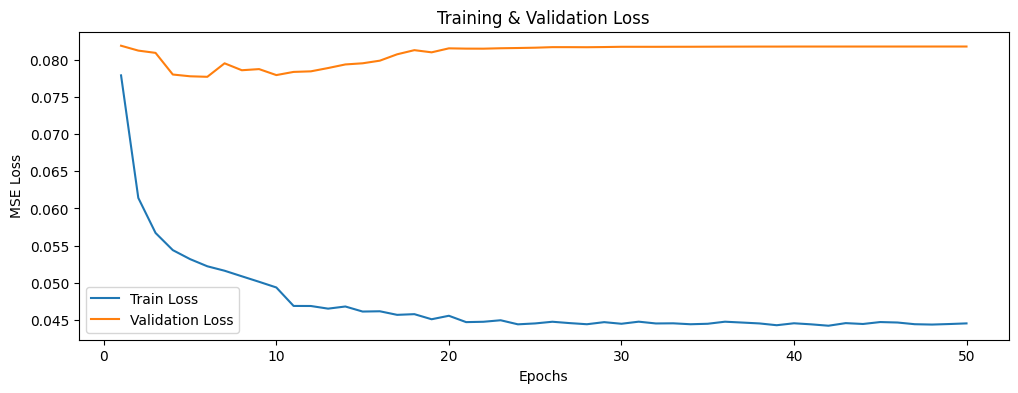

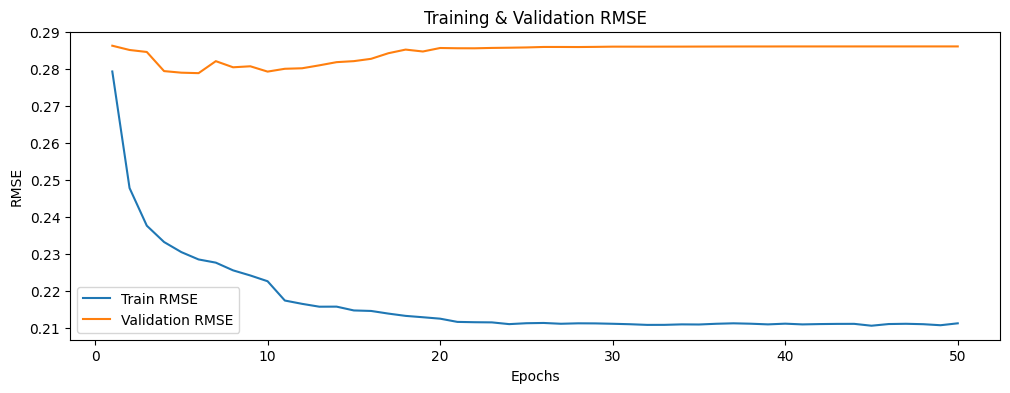

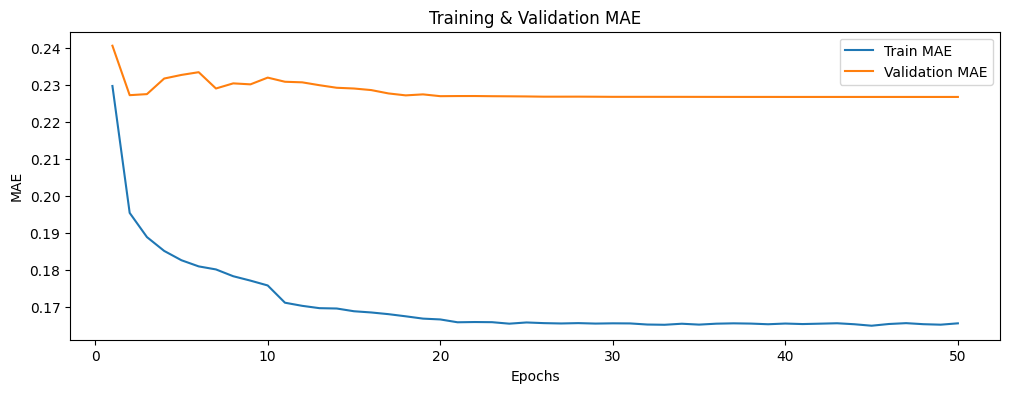

In [12]:
import matplotlib.pyplot as plt

# Perte
plt.figure(figsize=(12,4))
plt.plot(history['epoch'], history['train_loss'], label='Train Loss')
plt.plot(history['epoch'], history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# RMSE
plt.figure(figsize=(12,4))
plt.plot(history['epoch'], history['train_rmse'], label='Train RMSE')
plt.plot(history['epoch'], history['val_rmse'], label='Validation RMSE')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Training & Validation RMSE")
plt.legend()
plt.show()

# MAE
plt.figure(figsize=(12,4))
plt.plot(history['epoch'], history['train_mae'], label='Train MAE')
plt.plot(history['epoch'], history['val_mae'], label='Validation MAE')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training & Validation MAE")
plt.legend()
plt.show()


In [14]:
def recommend_for_user(user_id, top_k=10):
    user_movies = set(data[data['user_id']==user_id]['movie_id'])
    all_movies = set(range(movie_count))
    unseen_movies = np.array(list(all_movies - user_movies))
    
    user_tensor = torch.tensor([user_id]*len(unseen_movies)).to(device)
    movie_tensor = torch.tensor(unseen_movies).to(device)
    
    ncf.eval()
    with torch.no_grad():
        preds = ncf(user_tensor, movie_tensor).cpu().numpy().flatten()
    
    top_idx = preds.argsort()[::-1][:top_k]
    recommended_movie_ids = unseen_movies[top_idx]
    
    return movies.loc[movies['movie_id'].isin(recommended_movie_ids), ['title']]

# Exemple : recommandations pour l'utilisateur 0
recommend_for_user(0, top_k=5)


,title
818,Eddie (1996)
1129,Jupiter's Wife (1994)
1198,Cemetery Man (Dellamorte Dellamore) (1994)
1238,Cutthroat Island (1995)
1254,Broken English (1996)
